In [5]:
import pandas as pd

# List the file names for the three days
files = [
    'prices_round_3_day_0.csv',
    'prices_round_3_day_1.csv',
    'prices_round_3_day_2.csv'
]

# Load each CSV file from the directory and store the DataFrames in a list
dfs = [pd.read_csv(f'./round-3-island-data-bottle/{file}', delimiter=';') for file in files]

# Concatenate all DataFrames into one, resetting the index
df_all = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df_all.head())

   day  timestamp                      product  bid_price_1  bid_volume_1  \
0    0          0  VOLCANIC_ROCK_VOUCHER_10500         99.0          19.0   
1    0          0                      DJEMBES      13493.0          72.0   
2    0          0                   CROISSANTS       4321.0         111.0   
3    0          0                         JAMS       6631.0         210.0   
4    0          0  VOLCANIC_ROCK_VOUCHER_10000        505.0          19.0   

   bid_price_2  bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
0          NaN           NaN          NaN           NaN          100   
1          NaN           NaN          NaN           NaN        13494   
2          NaN           NaN          NaN           NaN         4322   
3          NaN           NaN          NaN           NaN         6633   
4          NaN           NaN          NaN           NaN          506   

   ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
0            19          NaN   

<Axes: >

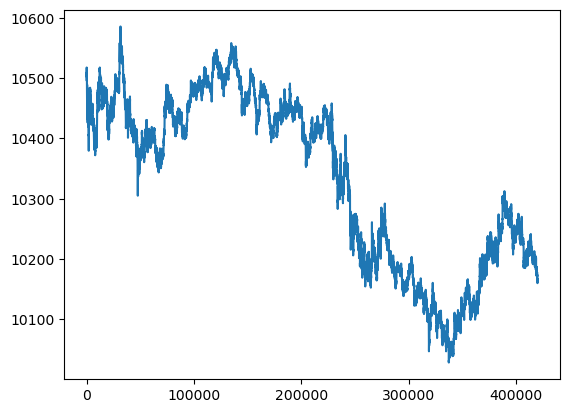

In [23]:
df_all[df_all['product'] == 'VOLCANIC_ROCK']['mid_price'].plot()

<Axes: >

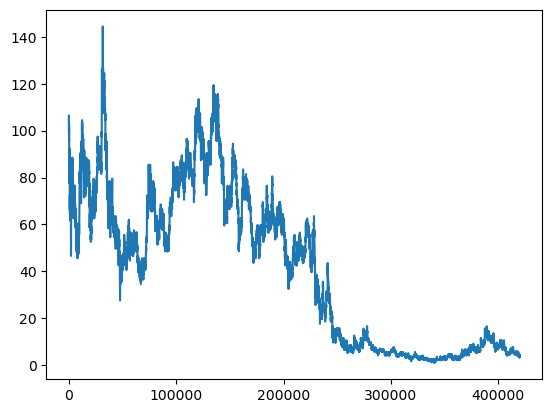

In [24]:
df_all[df_all['product'] == 'VOLCANIC_ROCK_VOUCHER_10500']['mid_price'].plot()

<Axes: >

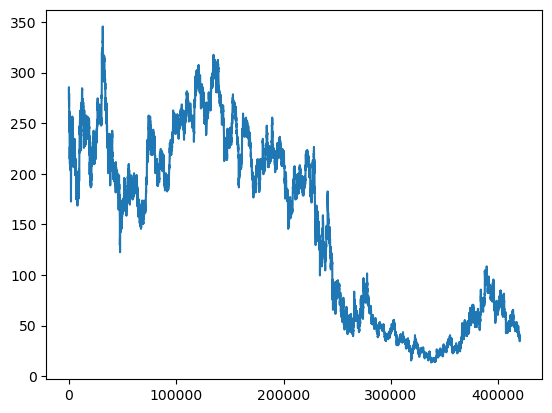

In [25]:
df_all[df_all['product'] == 'VOLCANIC_ROCK_VOUCHER_10250']['mid_price'].plot()

In [10]:
Voucher10500 = df_all[df_all['product'] == 'VOLCANIC_ROCK_VOUCHER_10500']

In [11]:
Rock = df_all[df_all['product'] == 'VOLCANIC_ROCK']

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq

# Black-Scholes call price function.
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Black-Scholes put price function.
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Function to compute implied volatility given an option price,
# choosing the proper pricing function based on the option type.
def implied_volatility(option_price, S, K, T, r, option_type, tol=1e-6, sigma_low=1e-6, sigma_high=5.0):
    def error(sigma):
        if option_type == 'call':
            return black_scholes_call(S, K, T, r, sigma) - option_price
        elif option_type == 'put':
            return black_scholes_put(S, K, T, r, sigma) - option_price
        else:
            raise ValueError("option_type must be 'call' or 'put'")
    return brentq(error, sigma_low, sigma_high, xtol=tol)

# Parameters
T = 7 / 365   # time to maturity in years
r = 0.01      # risk-free interest rate

# Extract the underlying asset ("Rock") mid price.
rock = df_all[df_all['product'] == 'VOLCANIC_ROCK']
S = rock['mid_price'].iloc[0]

# Define voucher products with their strike prices and option types.
# (Adjust these entries so that the key names match the ones in your DataFrame.)
voucher_products = {
    'VOLCANIC_ROCK_VOUCHER_9750': {'strike': 9750, 'option_type': 'call'},
    'VOLCANIC_ROCK_VOUCHER_10000': {'strike': 10000, 'option_type': 'call'},
    'VOLCANIC_ROCK_VOUCHER_10250': {'strike': 10250, 'option_type': 'call'},
    'VOLCANIC_ROCK_VOUCHER_10500': {'strike': 10500, 'option_type': 'call'},
    # Add or adjust entries as needed.
}

# List to store the results.
results = []

# Iterate through each voucher product.
for product, details in voucher_products.items():
    K = details['strike']
    option_type = details['option_type']
    voucher = df_all[df_all['product'] == product]
    if voucher.empty:
        # Skip this product if it doesn't exist in the DataFrame.
        continue

    # Extract the observed mid price for the option.
    option_market_price = voucher['mid_price'].iloc[0]
    
    # Calculate implied volatility.
    try:
        sigma_impl = implied_volatility(option_market_price, S, K, T, r, option_type)
    except Exception as e:
        sigma_impl = np.nan
        print(f"Error computing volatility for product {product}: {e}")
    
    # Calculate d1 and then delta, if volatility was determined.
    if np.isnan(sigma_impl):
        delta = np.nan
    else:
        d1 = (np.log(S/K) + (r + 0.5 * sigma_impl**2) * T) / (sigma_impl * np.sqrt(T))
        if option_type == 'call':
            delta = norm.cdf(d1)
        elif option_type == 'put':
            delta = norm.cdf(d1) - 1
    
    # Append the result.
    results.append({
        'product': product,
        'strike': K,
        'option_type': option_type,
        'option_market_price': option_market_price,
        'implied_volatility': sigma_impl,
        'delta': delta
    })

# Convert the results to a DataFrame and print.
results_df = pd.DataFrame(results)
print(results_df)

Error computing volatility for product VOLCANIC_ROCK_VOUCHER_9750: f(a) and f(b) must have different signs
                       product  strike option_type  option_market_price  \
0   VOLCANIC_ROCK_VOUCHER_9750    9750        call                754.5   
1  VOLCANIC_ROCK_VOUCHER_10000   10000        call                505.5   
2  VOLCANIC_ROCK_VOUCHER_10250   10250        call                273.5   
3  VOLCANIC_ROCK_VOUCHER_10500   10500        call                 99.5   

   implied_volatility     delta  
0                 NaN       NaN  
1            0.148551  0.991918  
2            0.169486  0.855146  
3            0.167162  0.512844  


## t